In [ ]:
# EXECUTAR NO TERMINAL:

# !pip install pandas
# !pip install openpyxl
# !pip install tensorflow
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install natsort

## BIBLIOTECAS

In [16]:
# Bibliotecas para data-science
import pandas as pd   #Biblioteca para Dataframes
#import dask.dataframe as dd  #Alternativa para pandas
import os   #Biblioteca para acesso dos arquivos
import numpy as np  #Biblioteca numérica
from natsort import natsorted   #Biblioteca para organização dos arquivos

# Bibliotecas para problemas de otimização
from amplpy import AMPL     #Biblioteca para otimização

# Bibliotecas para redes neurais
import tensorflow as tf
import h5py
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K  #Função para resetar a rede criada

# Bibliotecas gráficas
import matplotlib.pyplot as plt  #Biblioteca para plotar gráfico
from mpl_toolkits.mplot3d import Axes3D #Função para gerar gráfico 3D
from matplotlib.lines import Line2D #Função para gerar a legenda do gráfico com dois eixos Y
import cairosvg

# Bibliotecas para medição de tempo
import time

# Biblioteca para multiprocessamento
from multiprocessing import Pool, cpu_count

# Possíveis bibliotecas úteis:
# import sympy as sp   #Biblioteca simbólica
# import scipy as scp  #Biblioteca matemática geral

# PANDAS

## Código Principal

### Definição das Variáveis

In [2]:
# Nova organização das variáveis

# IEMA

dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\IEMA'

anos = sorted(list(set(os.listdir(dir)) - {'desktop.ini'}))   #Listar e ordenar os diretórios dos anos
horas = []  # Vetor para definir horas dos anos estudados
for i in anos:
  horas.append(8784) if int(i) % 4 == 0 else horas.append(8760)

iema = {}
iema_emi_usinas = {}
#iema_ger_usinas = {}
sheets = [0,1]

for i in anos:
  iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

  #iema_ger_usinas[i] = set(iema[i][0]['Usina'])
  iema_emi_usinas[i] = set(iema[i][1]['Usina'])

#iema_ger_usinas = set.intersection(*iema_ger_usinas.values())
#iema_emi_usinas = set.intersection(*iema_emi_usinas.values())
usinas = set.intersection(*iema_emi_usinas.values())

################################################################################################

# Código para somar os valores de emissões de todos os anos IEMA

# dfs_filtrados = []

# # Filtrar os dados das usinas comuns e preparar para a soma das emissões
# for i in anos:
#     # Filtrar o DataFrame para manter apenas as usinas comuns
#     df_filtrado = iema[i][1][iema[i][1]['Usina'].isin(usinas)]
    
#     # Separar as colunas numéricas e não numéricas
#     df_numerico = df_filtrado.select_dtypes(include=[float, int])
#     df_nao_numerico = df_filtrado.select_dtypes(exclude=[float, int])
    
#     # Manter a coluna 'Usina' em df_nao_numerico para poder combinar depois
#     df_nao_numerico['Usina'] = df_filtrado['Usina']
    
#     # Adicionar o DataFrame numérico à lista, com 'Usina' como índice
#     df_numerico['Usina'] = df_filtrado['Usina']
#     dfs_filtrados.append(df_numerico.set_index('Usina'))

# # Concatenar os DataFrames numéricos ao longo das linhas, mantendo os índices das usinas
# df_concatenado = pd.concat(dfs_filtrados)

# # Somar os dados numéricos das usinas comuns, agrupando por 'Usina'
# df_soma = df_concatenado.groupby('Usina').sum()

# # Unir as colunas não numéricas ao resultado final
# df_final = df_nao_numerico.drop_duplicates(subset='Usina').set_index('Usina').join(df_soma)

# # Se quiser resetar o índice para ter 'Usina' como uma coluna
# df_final = df_final.reset_index()

# # Exibir o DataFrame resultante
# display(df_final)

################################################################################################

# ONS

dir = "G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\ONS"

ons = {}
ons_total = []

# Acessar o drive e armazenar os dados
for ano in anos:
  dir_ano = os.path.join(dir, ano)

  # Listar e ordenar os arquivos CSV dentro do diretório do ano usando natsorted
  arq_csv = natsorted([f for f in os.listdir(dir_ano) if f.endswith('.csv')])

  for arquivo in arq_csv:
  # Ler os arquivos CSV e armazená-los em uma lista de DataFrames
    df_ano = pd.read_csv(os.path.join(dir_ano, arquivo), delimiter = ";")

  # Concatenar os DataFrames do ano e adicionar à lista total
    ons_total.append(df_ano)

# Concatenar todos os DataFrames dos anos em um único DataFrame final
ons_total = pd.concat(ons_total, ignore_index=True)

# Separação em usinas térmicas
ons_total = ons_total.loc[ons_total['nom_tipousina']=='TÉRMICA']

# Remover colunas desnecessárias
ons_total = ons_total.drop(columns=['id_subsistema',
                        'nom_subsistema',
                        'nom_estado',
                        'cod_modalidadeoperacao',
                        'nom_tipousina',
                        'ceg',
                        'id_ons'])

# Trocar o nome das colunas restantes
ons_total = ons_total.rename(columns={'din_instante':'Dia-Hora',
                          'id_estado':'Estado',
                          'nom_tipocombustivel':'Combustível',
                          'nom_usina':'Usina',
                          'val_geracao':'Geração'})

ons_total = ons_total[ons_total['Usina'].isin(usinas)]   # ESTÁ FALTANDO 4 USINAS, VERIFICAR OS NOMES NA PLANILHA IEMA (VERIFICAR INFORMAÇÃO)

for i in usinas:
  if len(ons_total.loc[ons_total['Usina'] == i]) == sum(horas):
    ons[i] = ons_total.loc[ons_total['Usina'] == i]

usinas = ons.keys()

#############################################################################################################################

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(dir,arq,arm,ano):
  if os.path.exists(dir):
    if os.path.isfile(f'{dir}\\{arq}') == False:
      arm[ano].to_csv(f'{dir}\\{arq}',index=False)
  else:
    os.makedirs(f'{dir}')
    arm[ano].to_csv(f'{dir}\\{arq}',index=False)

for i in usinas:
  arm = {}
  start_idx = 0
  dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{i}\\Dados de Geração'

  for j, ano in enumerate(anos):

    arq = f'{i}_{ano}.csv'
    
    # Índice final para o ano atual
    end_idx = start_idx + horas[j]
    
    # Armazene os dados do ano no dicionário
    arm[ano] = ons[i].iloc[start_idx:end_idx]
    
    # Atualize o índice inicial para o próximo ano
    start_idx = end_idx
    armazenar(dir,arq,arm,ano)

### Problema de Otimização - AMPL

In [49]:
def ampl_model(ons_ampl,iema_ampl,usina):
    # Inicializar o ambiente AMPL
    ampl = AMPL()

    # Definir o modelo AMPL usando ampl.eval
    ampl.eval(r'''
            
    set x;  # Quantidade de anos a serem estudados
    set y;  # Quantidade de horas do ano
              
    param HorasAno{x};  # Número de horas para cada ano, considerando bissextos
            
    param PG{x,y};
    param E{x};

    var alpha;
    var beta;
    var gamma;
    var omega;
    var mu;

    minimize Obj:
        (1 / card{x}) * sum {i in x} (sum {j in y: j <= HorasAno[i] and PG[i,j] != 0} ((alpha * PG[i,j]^2 + beta * PG[i,j] + gamma + omega * exp(mu * PG[i,j]) - E[i])^2) + 1e-12);
              
    subject to ALPHA: alpha >= 0;
    subject to BETA: beta >= 0;
    subject to GAMMA: gamma >= -omega;
    subject to OMEGA: omega >= 0;
    subject to MU: mu >= 0;
    ''')

    ampl.set['x'] = list(range(1,len(anos)+1))
    ampl.set['y'] = list(range(1, 8784 + 1))

    # Definindo o parâmetro 'HorasAno'
    horas_ano = {}
    for i, ano in enumerate(anos, start=1):
        horas_ano[i] = 8784 if int(ano) % 4 == 0 else 8760
    ampl.param['HorasAno'] = horas_ano

    for i, ano in enumerate(anos, start=1):
        for j, valor in enumerate(ons_ampl[i], start=1):
            # Certifique-se de que 'j' está dentro do intervalo de horas para o ano 'ano'
            if j <= horas_ano[i]:
                ampl.eval(f'let PG[{i},{j}] := {valor};')

    ampl.param['E'] = iema_ampl

    # Resolver o modelo
    ampl.setOption('solver','C:\\Users\\Giovanni\\Documents\\ipopt\\bin\\ipopt')
    ampl.solve()

    # Obter os valores das variáveis de decisão
    alpha = ampl.var['alpha'].value()
    beta = ampl.var['beta'].value()
    gamma = ampl.var['gamma'].value()
    omega = ampl.var['omega'].value()
    mu = ampl.var['mu'].value()

    print(alpha)
    print(beta)
    print(gamma)
    print(omega)
    print(mu)

    #Salvando os resultados
    tab = pd.DataFrame({'Coeficientes':['Alpha','Beta','Gamma','Omega','Mu'],'Valores':[alpha,beta,gamma,omega,mu]})
    tab.to_csv(f'{dir2}\\{usina}_{metodo_objetivo}_{pu_mw}_3_anos.csv',index=False)

    #Limpando o modelo para disponibilizar armazenamento na memória
    #del ampl_model

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)'
metodo_objetivo = 'MSE'  # MSE / RMSE  (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'   # MW / PU  (ALTERAR DADOS DE GERAÇÃO)

###############################################################################################################################

# Definição da variável ons_ampl
for usina in usinas:
    ons_ampl = {}
    start_idx = 0
    
    for j, ano in enumerate(anos):
        
        # Índice final para o ano atual
        end_idx = start_idx + horas[j] 
        
        # Armazene os dados do ano no dicionário
        ons_ampl[j+1] = ons[usina]['Geração'].iloc[start_idx:end_idx]
        
        # Atualize o índice inicial para o próximo ano
        start_idx = end_idx

    # Converte os dados para lista
    ons_ampl = {key: valor.tolist() for key, valor in ons_ampl.items()}

    # Definição da variável iema_ampl

    iema_ampl = []

    for ano in iema.keys():
        # Verifica se a usina está presente no DataFrame e extrai a emissão correspondente
        iema_ampl.append(iema[ano][1].loc[iema[ano][1]['Usina'] == usina, 'Gases Emitidos (MIL TONELADAS DE CO2e)'].values[0])

    # Iniciando a otimização
    dir2 = f'{dir}\\{usina}\\Coeficientes\\AMPL'
    if os.path.exists(dir2):
        if os.path.isfile(f'{dir2}\\{usina}_{metodo_objetivo}_{pu_mw}.csv') == False:
            ampl_model(ons_ampl,iema_ampl,usina)
    else:
        os.makedirs(f'{dir2}')
        ampl_model(ons_ampl,iema_ampl,usina)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

### Criação das Emissões Sintéticas

In [50]:
# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

metodo_objetivo = 'MSE'  # MSE / RMSE
pu_mw = 'MW'   # MW / PU

for usina in usinas: 
  dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}'
  arq = f'Coeficientes\\AMPL\\{usina}_{metodo_objetivo}_{pu_mw}_3_anos'

  PG = list(ons[usina]['Geração'])
  em = []

  if os.path.isfile(f'{dir}\\{arq}.csv') == True:
    tab = pd.read_csv(f'{dir}\\{arq}.csv')

    alpha = tab['Valores'].loc[tab['Coeficientes'] == 'Alpha'].item()
    beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
    gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
    omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
    mu = tab['Valores'].loc[tab['Coeficientes'] == 'Mu'].item()

  for k in range(len(PG)):
    em.append((alpha * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mu * PG[k]))

  start_idx = 0
  for j, ano in enumerate(anos):

    # Índice final para o ano atual
    end_idx = start_idx + horas[j]

    # Dados para a planilha a ser gerada
    data={
        'Dia-Hora': list(ons[usina]['Dia-Hora'].iloc[start_idx:end_idx]),
        'Combustível': list(ons[usina]['Combustível'].iloc[start_idx:end_idx]),
        'Usina': list(ons[usina]['Usina'].iloc[start_idx:end_idx]),
        'Emissão': em[start_idx:end_idx]
      }
    
    df = pd.DataFrame(data)

    # # Atualize o índice inicial para o próximo ano
    start_idx = end_idx

    if os.path.exists(f'{dir}\\Emissões Sintéticas (Todos os anos)'):
      if os.path.isfile(f'{dir}\\Emissões Sintéticas (Todos os anos)\\{usina}_{ano}.csv') == False:
        df.to_csv(f'{dir}\\Emissões Sintéticas (Todos os anos)\\{usina}_{ano}.csv',index=False)
    else:
      os.makedirs(f'{dir}\\Emissões Sintéticas (Todos os anos)')
      df.to_csv(f'{dir}\\Emissões Sintéticas (Todos os anos)\\{usina}_{ano}.csv',index=False)

### Tratamento dos Dados - Geral

In [3]:
tab_temp = ons_total[ons_total['Usina'].isin(usinas)]

temp = []
for i in iema:
    temp.append(iema[i][1])
    iema_temp = pd.concat(temp)

iema_temp = iema_temp.drop_duplicates(subset='Usina')

temp = pd.merge(tab_temp,iema_temp,how='left',on='Usina')

data = {
    'Dia-Hora':temp['Dia-Hora'],
    'Usina':temp['Usina'],
    'Geração':temp['Geração'],
    'Combustível':temp['Combustível_x'],
    'Ciclo de Operação':temp['Ciclo de Operação'],
    'Potência Instalada': temp['Potência Instalada (MW)']
}

temp = pd.DataFrame(data)
temp = temp.dropna(subset='Ciclo de Operação')

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['Combustível','Ciclo de Operação'])],remainder='passthrough')
x=ct.fit_transform(temp)

colunas = ['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Dia-Hora','Usina','Geração','Potência Instalada']

tab_trat = pd.DataFrame(x,columns=colunas)

### Tratamento dos Dados - Específico

In [4]:
usinas_estudadas = ['Baixada Fluminense','Norte Fluminense','Santa Cruz','Termorio']
usina_serie = tab_trat['Usina']

if not usinas_estudadas:
    raise ValueError(f'Nenhuma usina a ser estudada.')
elif not all(usina in usinas for usina in usinas_estudadas):
    raise ValueError(f'Usinas não listadas.')

temp = []
for usina in usinas_estudadas:

    dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\Emissões Sintéticas (Todos os anos)'
    arq = sorted([f for f in os.listdir(dir) if f.endswith('.csv')])

    for arquivo in arq:
        dir_comp = os.path.join(dir,arquivo)
        temp.append(pd.read_csv(dir_comp))

    emi = pd.concat(temp)


def preservar_usinas(x):
    return ', '.join(sorted(set(x)))

def verificar_combustiveis(x):
    combustiveis_unicos = sorted(set(x))
    if len(combustiveis_unicos) > 1:
        raise ValueError(f'Erro: Mais de um tipo de combustível encontrado: {', '.join(combustiveis_unicos)}')
    return combustiveis_unicos[0]
                         
emi = emi.groupby(['Dia-Hora']).agg({
    'Usina': preservar_usinas,
    'Emissão': 'sum',             # Soma as emissões
    'Combustível': verificar_combustiveis
})

x = tab_trat[['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Geração','Potência Instalada']]

# Definição das variáveis de treino e teste
sc = StandardScaler() # Transforma variáveis categóricas em numéricas
x = sc.fit_transform(x)

x = pd.DataFrame({'Coluna1': x[:, 0], 
                  'Coluna2': x[:, 1], 
                  'Coluna3': x[:, 2], 
                  'Coluna4': x[:, 3], 
                  'Coluna5': x[:, 4], 
                  'Coluna6': x[:, 5], 
                  'Coluna7': x[:, 6], 
                  'Coluna8': x[:, 7], 
                  'Geração': x[:, 8], 
                  'Potência Instalada': x[:, 9], 
                  'Usina': usina_serie,
                  'Dia-Hora': tab_trat['Dia-Hora']})

x = x.loc[x['Usina'].isin(usinas_estudadas)]

x = x.groupby(['Dia-Hora']).agg({
    'Usina': preservar_usinas,
    'Coluna1':'sum',
    'Coluna2':'sum',
    'Coluna3':'sum',
    'Coluna4':'sum',
    'Coluna5':'sum',
    'Coluna6':'sum',
    'Coluna7':'sum',
    'Coluna8':'sum',
    'Geração':'sum',
    'Potência Instalada': 'sum'
})

x = x.drop(['Usina'],axis=1)
y = emi['Emissão']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

### Criação Rede Neural

In [5]:
K.clear_session()   #Limpar redes geradas anteriormente
rede = tf.keras.Sequential()

rede.add(tf.keras.layers.Dense(64,activation='relu'))
rede.add(tf.keras.layers.Dense(64,activation='relu'))
rede.add(tf.keras.layers.Dense(64,activation='relu'))
rede.add(tf.keras.layers.Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rede.compile(optimizer=opt, loss='mean_squared_error')

### Treino e Execução da Rede Neural

In [6]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# While para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i=0
#while True:
i+=1
rede.fit(x_train,y_train,epochs=2000,verbose=0)
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')
    # if mse_result < 20:
    #     tac = time.time()
    #     break
    # tempo_exec = tac - tic
    # print(f'\nTempo de Execução: {tempo_exec}')

#Salvar os pesos no diretório
# if usina == '':
#     dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Código'
#     rede.save_weights(f'{dir}\\Pesos_Geral.weights.h5')
# else:
#     dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\Pesos'
#     if os.path.exists(dir):
#         if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
#             rede.save_weights(f'{dir}\\{usina}.weights.h5')
#     else:
#         os.makedirs(f'{dir}')
#         rede.save_weights(f'{dir}\\{usina}.weights.h5')

658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
MSE Geração 1: 9.319421043330253e+16


### Execução da Rede à Partir de Pesos Salvos (Necessário executar o treino da rede uma vez)

In [ ]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# Carregar os pesos
dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\Pesos'
rede.load_weights(f'{dir}/{usina}.weights.h5')

# Executa a rede
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')

### Gerar os gráficos de todas as usinas

In [ ]:
for usina in usinas:
    usinas_estudadas = list(usina.split(','))
    usina_serie = tab_trat['Usina']

    if not usinas_estudadas:
        raise ValueError(f'Nenhuma usina a ser estudada.')
    elif not all(usina in usinas for usina in usinas_estudadas):
        raise ValueError(f'Usinas não listadas.')
    elif os.path.isfile(f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\{usina}.png') == False:
        temp = []
        for i in usinas_estudadas:

            dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{i}\\Emissões Sintéticas (Todos os anos)'
            arq = sorted([f for f in os.listdir(dir) if f.endswith('.csv')])

            for arquivo in arq:
                dir_comp = os.path.join(dir,arquivo)
                temp.append(pd.read_csv(dir_comp))

            emi = pd.concat(temp)


        def preservar_usinas(x):
            return ', '.join(sorted(set(x)))

        def verificar_combustiveis(x):
            combustiveis_unicos = sorted(set(x))
            if len(combustiveis_unicos) > 1:
                raise ValueError(f'Erro: Mais de um tipo de combustível encontrado: {', '.join(combustiveis_unicos)}')
            return combustiveis_unicos[0]
                                
        emi = emi.groupby(['Dia-Hora']).agg({
            'Usina': preservar_usinas,
            'Emissão': 'sum',             # Soma as emissões
            'Combustível': verificar_combustiveis
        })

        x = tab_trat[['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Geração','Potência Instalada']]

        # Definição das variáveis de treino e teste
        sc = StandardScaler() # Transforma variáveis categóricas em numéricas
        x = sc.fit_transform(x)

        x = pd.DataFrame({'Coluna1': x[:, 0], 
                        'Coluna2': x[:, 1], 
                        'Coluna3': x[:, 2], 
                        'Coluna4': x[:, 3], 
                        'Coluna5': x[:, 4], 
                        'Coluna6': x[:, 5], 
                        'Coluna7': x[:, 6], 
                        'Coluna8': x[:, 7], 
                        'Geração': x[:, 8], 
                        'Potência Instalada': x[:, 9], 
                        'Usina': usina_serie,
                        'Dia-Hora': tab_trat['Dia-Hora']})

        x = x.loc[x['Usina'].isin(usinas_estudadas)]

        x = x.groupby(['Dia-Hora']).agg({
            'Usina': preservar_usinas,
            'Coluna1':'sum',
            'Coluna2':'sum',
            'Coluna3':'sum',
            'Coluna4':'sum',
            'Coluna5':'sum',
            'Coluna6':'sum',
            'Coluna7':'sum',
            'Coluna8':'sum',
            'Geração':'sum',
            'Potência Instalada': 'sum'
        })

        x = x.drop(['Usina'],axis=1)
        y = emi['Emissão']

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


        K.clear_session()   #Limpar redes geradas anteriormente
        rede = tf.keras.Sequential()

        rede.add(tf.keras.layers.Dense(64,activation='relu'))
        rede.add(tf.keras.layers.Dense(64,activation='relu'))
        rede.add(tf.keras.layers.Dense(64,activation='relu'))
        rede.add(tf.keras.layers.Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        rede.compile(optimizer=opt, loss='mean_squared_error')

        # Inicializa a medição do erro quadrático médio
        mse = tf.keras.metrics.MeanSquaredError()

        # While para treinar a rede N vezes até atingir um erro satisfatório
        tic = time.time()
        rede.fit(x_train,y_train,epochs=2000,verbose=0)
        y_pred = rede.predict(x_train)

        mse.update_state(y_train, y_pred)
        mse_result = mse.result().numpy()

        # Gráfico com dois eixos Y

        x_fig = np.linspace(0,len(y_pred),len(x_test))
        tempo_inicio = 0
        tempo_fim = 1000

        ger = tab_trat[['Dia-Hora','Geração']].loc[tab_trat['Usina'].isin(usinas_estudadas)]
        ger = ger.groupby('Dia-Hora').sum()

        fig,ax1 = plt.subplots()

        ax1.set_xlabel('Intervalo de Discretização [Hora]')
        ax1.set_ylabel('Potência Gerada [MW]')
        ax1.plot(x_fig[tempo_inicio:tempo_fim],ger[tempo_inicio:tempo_fim],color='r')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Toneladas CO2-e/h')
        ax2.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim],color='b')
        ax2.grid(True)

        # Adicionando legendas personalizadas
        legend_elements = [
            Line2D([0], [0], color='r', lw=2, label='Geração'),
            Line2D([0], [0], color='b', lw=2, label='Emissão'),
            Line2D([0], [0], color='w', lw=0, label=f'Potência Instalada: {iema_temp['Potência Instalada (MW)'].loc[iema_temp['Usina'] == usina].values[0]:.0f}MW'),
            Line2D([0], [0], color='w', lw=0, label=f'Ciclo de Operação: {iema_temp['Ciclo de Operação'].loc[iema_temp['Usina'] == usina].values[0]}'),
            Line2D([0], [0], color='w', lw=0, label=f'Combustível: {iema_temp['Combustível'].loc[iema_temp['Usina'] == usina].values[0]}')]

        # Unindo as legendas
        ax2.legend(handles=legend_elements, loc='best', fontsize='small', facecolor='white', framealpha=1)

        dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}'
        plt.savefig(f'{dir}\\{usina}.png')
        print(f'Gráfico referente à usina {usina} gerado.\n')

## Gráficos

### Gráficos 2D

#### Gráfico com um eixo Y

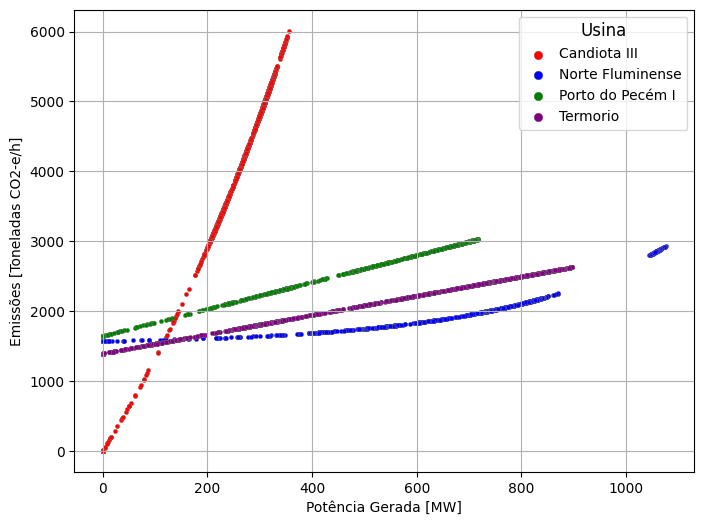

In [74]:
# Gráfico Emissão x Geração

usinas_grafico = ['Candiota III','Norte Fluminense', 'Porto do Pecém I', 'Termorio']
cores = ['r','b','g','purple']

tempo_inicio = 0
tempo_fim = 1000

ger_cand = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Candiota III\\Dados de Geração\\Candiota III_2020.csv')
emi_cand = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Candiota III\\Emissões Sintéticas (Todos os anos)\\Candiota III_2020.csv')

ger_nor_flu = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Norte Fluminense\\Dados de Geração\\Norte Fluminense_2020.csv')
emi_nor_flu = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Norte Fluminense\\Emissões Sintéticas (Todos os anos)\\Norte Fluminense_2020.csv')

ger_pecem = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Porto do Pecém I\\Dados de Geração\\Porto do Pecém I_2020.csv')
emi_pecem = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Porto do Pecém I\\Emissões Sintéticas (Todos os anos)\\Porto do Pecém I_2020.csv')

ger_term = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Termorio\\Dados de Geração\\Termorio_2020.csv')
emi_term = pd.read_csv('G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Termorio\\Emissões Sintéticas (Todos os anos)\\Termorio_2020.csv')

# Passo 3: Criar o gráfico de dispersão para cada usina
plt.figure(figsize=(8, 6))

# Usina Candiota III
plt.scatter(ger_cand['Geração'], emi_cand['Emissão']/100000, color='r', s=10, edgecolor='gray', linewidths=0.2, label='Candiota III')

# Usina Norte Fluminense
plt.scatter(ger_nor_flu['Geração'], emi_nor_flu['Emissão'], color='b', s=10, edgecolor='gray', linewidths=0.2, label='Norte Fluminense')

# Usina Porto do Pecém I
plt.scatter(ger_pecem['Geração'], emi_pecem['Emissão'], color='g', s=10, edgecolor='gray', linewidths=0.2, label='Porto do Pecém I')

# Usina Termorio
plt.scatter(ger_term['Geração'], emi_term['Emissão'], color='purple', s=10, edgecolor='gray', linewidths=0.2, label='Termorio')

# Passo 4: Configurar o gráfico
#plt.title('Emissões x Geração por Usina')
plt.xlabel('Potência Gerada [MW]')
plt.ylabel('Emissões [Toneladas CO2-e/h]')
plt.legend(title='Usina', fontsize=10, markerscale=2, scatterpoints=1, handletextpad=0.5, title_fontsize=12)
plt.grid(True)

# Passo 5: Exibir o gráfico
plt.show()


Regressão Norte Fluminense (MSE: 3.2651)


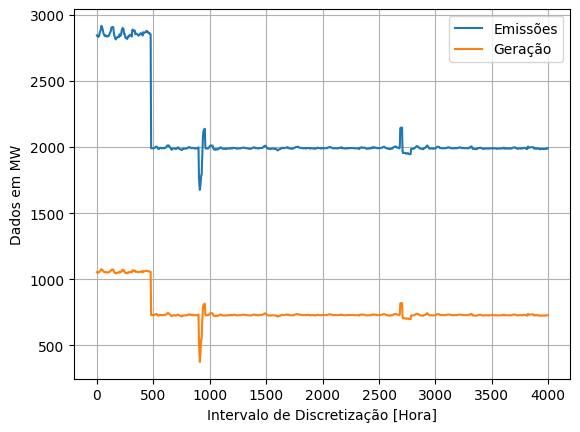

In [125]:
x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

ger = tab_trat[['Dia-Hora','Geração']].loc[tab_trat['Usina'].isin(usinas_estudadas)]
ger = ger.groupby('Dia-Hora').sum()

plt.figure()
plt.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim], x_fig[tempo_inicio:tempo_fim],ger[tempo_inicio:tempo_fim])
plt.legend(['Emissões','Geração'])
plt.xlabel('Intervalo de Discretização [Hora]')
plt.ylabel('Dados em MW')
#plt.title(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})')
plt.grid()
print(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})') if usina != '' else print('Regressão de todas as usinas')
plt.show()

#### Gráfico com dois eixos Y

Gráfico referente à usina Termorio



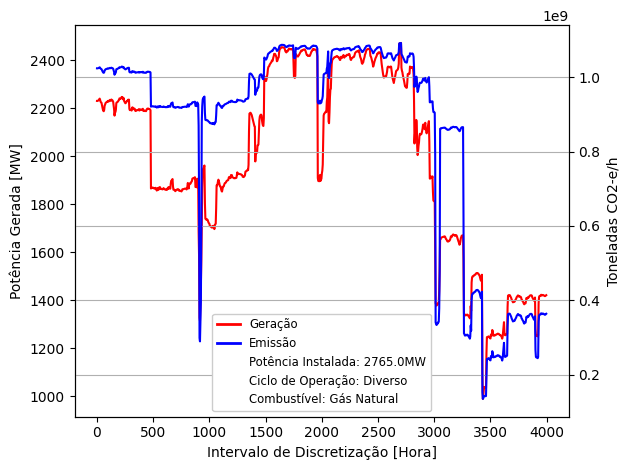

<Figure size 640x480 with 0 Axes>

In [11]:
# Gráfico com dois eixos Y

x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

ger = tab_trat[['Dia-Hora','Geração']].loc[tab_trat['Usina'].isin(usinas_estudadas)]
ger = ger.groupby('Dia-Hora').sum()

fig,ax1 = plt.subplots()

ax1.set_xlabel('Intervalo de Discretização [Hora]')
ax1.set_ylabel('Potência Gerada [MW]')
ax1.plot(x_fig[tempo_inicio:tempo_fim],ger[tempo_inicio:tempo_fim],color='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Toneladas CO2-e/h')
ax2.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim],color='b')
ax2.grid(True)

# Adicionando legendas personalizadas
legend_elements = [
    Line2D([0], [0], color='r', lw=2, label='Geração'),
    Line2D([0], [0], color='b', lw=2, label='Emissão'),
    Line2D([0], [0], color='w', lw=0, label=f'Potência Instalada: {iema_temp['Potência Instalada (MW)'].loc[iema_temp['Usina'].isin(usinas_estudadas)].sum()}MW'),
    Line2D([0], [0], color='w', lw=0, label=f'Ciclo de Operação: Diverso'),#{iema_temp['Ciclo de Operação'].loc[iema_temp['Usina'] == usina].values[0]}'),
    Line2D([0], [0], color='w', lw=0, label=f'Combustível: {iema_temp['Combustível'].loc[iema_temp['Usina'] == usina].values[0]}')]

# Unindo as legendas
ax2.legend(handles=legend_elements, loc='best', fontsize='small', facecolor='white', framealpha=1)

print(f'Gráfico referente à usina {usina}\n') if usina != '' else print('Gráfico referente à todas as usinas')
plt.show()
plt.savefig('grafico.png', format='png', bbox_inches='tight')
cairosvg.png2svg(url='grafico.png', write_to='grafico_convertido.svg')

### Gráfico 3D

In [ ]:
# Treino da Rede para Obter o Erro

neur_max = 20
z = np.array([])

dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Código'

for i in range(1, neur_max+1):

  for j in range(1, neur_max+1):
    K.clear_session()

    rede = tf.keras.Sequential()
    rede.add(tf.keras.layers.Dense(i,activation='relu'))
    rede.add(tf.keras.layers.Dense(j,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    rede.compile(optimizer=opt, loss='mean_squared_error')

    # Inicializa a medição do erro quadrático médio
    mse = tf.keras.metrics.MeanSquaredError()

    #Treinamento e teste da rede
    print(f'Treinando para {i} neurônio(os) na primeira camada e para {j} neurônio(os) na segunda camada')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    rede.fit(x_train,y_train,epochs=500,verbose=0)
    y_pred = rede.predict(x_train)

    mse.update_state(y_train, y_pred)
    z = np.append(z,mse.result().numpy())
    print(f'Treinamento concluído. Erro: {mse.result().numpy():.2f}\n')

np.savetxt(f'MSE Gás Natural - Gráfico 3D.txt', z)
print(f'Todos os valores de erro para usina {usina} salvos.')

In [ ]:
# Gráfico 3D relacionando erro pela quantia de neurônios

neur_max = 20
x = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    x = np.append(x,i+1)

y = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    y = np.append(y,j+1)

dir = f'C:\\Users\\Giovanni\\Documents\\Programação\\Python\\Iniciação Científica'

if os.path.isfile(f'{dir}\\MSE Gás Natural - Gráfico 3D.txt'):

  z = np.loadtxt(f'MSE Gás Natural - Gráfico 3D.txt')

  cm = 1/2.54
  fig = plt.figure(figsize=(40*cm,40*cm))
  ax = fig.add_subplot(111, projection='3d')

  # Plotando pontos
  ax.scatter(x, y, z, c='r', marker='o')

  # Plotando linhas (Opcional)
  # for i in range(len(x)):
  #     ax.plot([x[i], x[i]], [y[i], y[i]], [0, z[i]], color='b')

  # Plotando faces
  ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan',edgecolors='k')

  # Mudando o passo dos eixos
  ax.set_xticks(np.arange(0, 21, 2))  # Define os ticks do eixo x
  ax.set_yticks(np.arange(0, 21, 2))  # Define os ticks do eixo y
  #ax.set_zticks(np.arange(0, 1))  # Define os ticks do eixo z

  # Configurações adicionais
  ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
  ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
  ax.set_zlabel('Erro', fontsize=12,rotation=90)

  plt.show()

else:
  print(f'Erros para usina {usina} não gerados')

## Algoritmos Auxiliares (Definir as variáveis antes)

### Algoritmo para Preenchimento das Tabelas IEMA Utilizando uma Tabela Base (ARRUMAR)

In [ ]:
dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\IEMA'
tab_temp1 = {}
tab_temp2 = []

ano_base = input('Escolha o ano base: ')
tipo_base = input('Escolha a tabela base (Geração ou Emissão): ').upper()
ano_preencher = input('Escolha o ano a ser preenchido: ')
tipo_preencher = input('Escolha a tabela a ser preenchida (Geração ou Emissão): ').upper()

if (ano_base in iema.keys()) and (ano_preencher in iema.keys()) and (tipo_base == 'GERAÇÃO' or tipo_base == 'EMISSÃO') and (tipo_preencher == 'GERAÇÃO' or tipo_preencher == 'EMISSÃO'):

  if tipo_base == tipo_preencher and ano_base == ano_preencher:
    print('\nAVISO: Redundância nas informações. Verificar preenchimento solicitado.')

  else:
    tipo_base_num = 0 if tipo_base == 'GERAÇÃO' else 1
    tipo_preencher_num = 0 if tipo_preencher == 'GERAÇÃO' else 1

    tab_temp2 = pd.merge(iema[ano_base][tipo_base_num], iema[ano_preencher][tipo_preencher_num], how='right', on='Usina', suffixes=(f'_{ano_base}_{tipo_base}', f'_{ano_preencher}_{tipo_preencher}'))

    tab_temp2[f'Município_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Município_{ano_base}_{tipo_base}']
    tab_temp2[f'Estado_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Estado_{ano_base}_{tipo_base}']
    tab_temp2[f'Combustível_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Combustível_{ano_base}_{tipo_base}']
    tab_temp2[f'Ciclo de Operação_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Ciclo de Operação_{ano_base}_{tipo_base}']

    tab_temp1[ano_preencher] = tab_temp2.iloc[:, [0,7,8,10,11]]   # ARRUMAR PARA FAZER COM QUE SEJAM ESCOLHIDAS AS COLUNAS PELO NOME DELAS

    if os.path.isfile(f'{dir}/{ano_preencher}/IEMA {ano_preencher} {tipo_preencher}_Código.xlsx') == False:
      tab_temp1[ano_preencher].to_excel(f'{dir}/{ano_preencher}/IEMA {ano_preencher} {tipo_preencher}_Código.xlsx',index=False)
      print('\nAVISO: Geração de arquivo concluída. Verificar pasta daqui alguns segundos.')

    else:
      print('\nAVISO: Arquivo ja existente. Verificar pasta.')

else:
  print('\nAVISO: Informação não disponível ou erro de digitação.')